# Autoenkoderi

Autoenkoderi predstavljaju neuronske mreže koje pokušavaju da nauče funkciju `f(x)=x` tj. da reprodukuju svoj ulaz. Ovakve mreže se sastoje iz dva dela: enkodera i dekodera.

`Enkoder` predstavlja deo mreže koji ulaz dimenzije $A$ preslikava u vektor dimenzije $B$, pri čemu važi da je $A > B$, odnosno vrši se smanjivanje dimenzionalnosti. Vektor dimenzije $B$ nazivamo vektorom latentnog prostora dimenzije $B$.

`Dekoder` dobijeni vektor dimenzije $B$ preslikava u polazni vektor dimenzije $A$, odnosno vrši rekonstrukciju ulaza na osnovu vektora iz latentnog prostora.

<img src='assets/autoencoder_1.png'>

Treniranje autoenkodera se vrši kao obučavanje standardne neuronske mreže u klasifikacionim i regresionim problemima.
Ono što nas u radu sa njima najviše zanima je latentni prostor i reprezentacije ulaza koje su obično značajno manjih dimenzija. Na primer, u radu sa tekstom smo koristili pritrenirane GloVe i Word2Vec reprezentacije koje su dobijene treniranjem specifičnih autoenkodera. 

Sledeći primer prikazuje ipak nešto malo drugačiji scenario primene autoenkodera kojim se uklanja šum (engl. denoising autoencoder) sa slike.  

In [1]:
import sys
sys.path.append('..')
import matftorch

In [2]:
import torch
import torch.nn as nn

In [3]:
from torchvision.datasets import MNIST

In [4]:
from sklearn import model_selection

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [6]:
np.random.seed(1337)

In [7]:
dataset = MNIST('datasets', download=True)

Prvo ćemo učitati skup podataka. Same labele koje su pridružene instancama nisu od važnosti za autoenkodere.

In [8]:
X = dataset.data
X_train, X_test = model_selection.train_test_split(X, test_size=0.2, random_state=1337)

Sličice sa kojima radimo su dimenzija 28x28 i pripremićemo ih tako što ćemo ih ispraviti i normalizovati njihove vrednosti. Uz ovo, slikama ćemo pridružiti i dodatnu dimenziju sa vrednošću 1 koja predstavlja njihov kanal (slike su crno-bele).

In [9]:
print("X_train.shape", X_train.shape)

X_train.shape torch.Size([48000, 28, 28])


In [10]:
X_train.max()

tensor(255, dtype=torch.uint8)

In [11]:
H, W = X_train.shape[1:]
X_train.unsqueeze_(1)
X_test.unsqueeze_(1)
X_train = X_train.float() / 255
X_test = X_test.float() / 255

In [12]:
X_train.shape

torch.Size([48000, 1, 28, 28])

In [13]:
X_test.shape

torch.Size([12000, 1, 28, 28])

Dalje ćemo generisati šum iz raspodele $N(0.5, 0.5)$ koji ćemo dodati slikama. 

In [14]:
noise = torch.randn_like(X_train) * 0.5
X_train_noisy = X_train + noise

noise = torch.randn_like(X_test) * 0.5
X_test_noisy = X_test + noise

# odsecicemo vrednosti koje su nakon dodavanja suma ispale iz opsega [0, 1]
X_train_noisy = torch.clamp(X_train_noisy, 0., 1.)
X_test_noisy = torch.clamp(X_test_noisy, 0., 1.)

Prikazaćemo npr. 9 ovako dobijenih modifikovanih sličica.

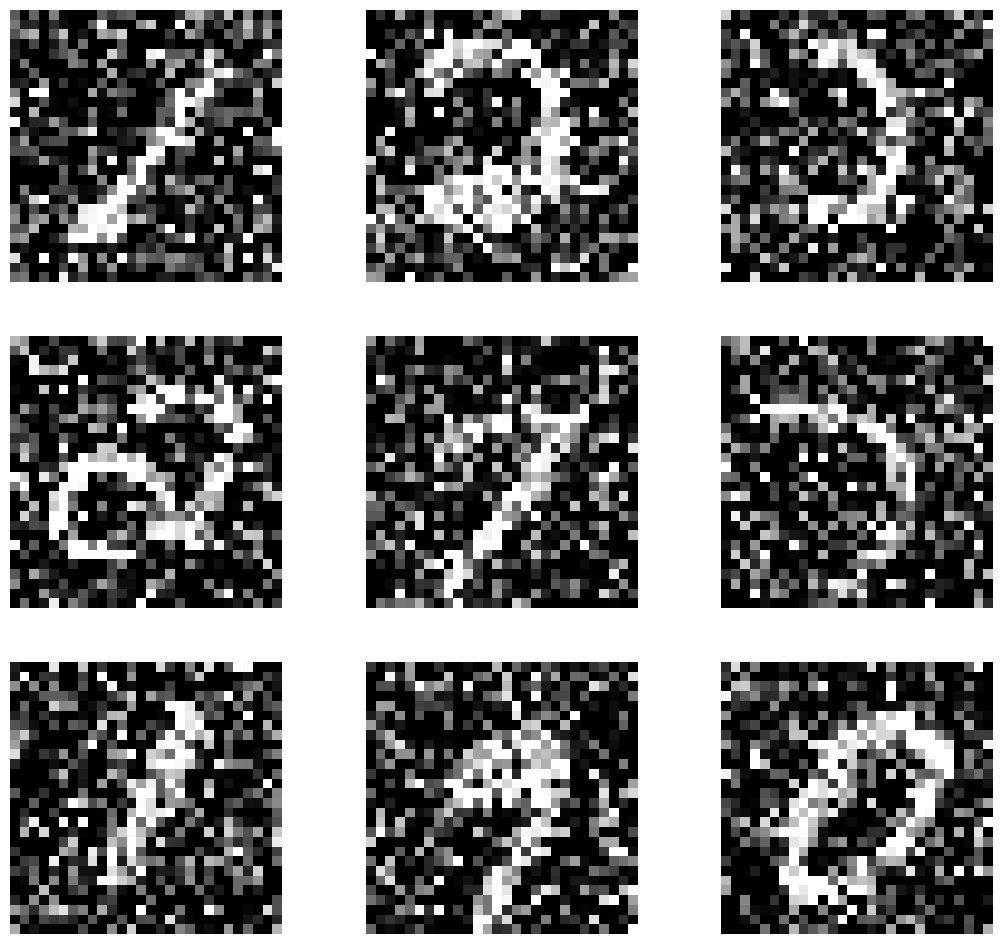

In [15]:
nrows = 3
ncols = 3

# pripremamo panel za crtanje svake od sličica
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(13, 12)

# izdvajamo nrows*ncols slika nasumicno
ix = np.random.randint(low=0, high=X_train_noisy.shape[0], size=nrows*ncols)
chosen_imgs = X_train_noisy[ix]

image_size = X_test_noisy.shape[2]
# svaku slicicu zasebno prikazujemo
i = 0
for row in ax:
    for col in row:
        # pre prikaza menjamo dimenziju slike iz (image_size, image_size, 1) 
        # u (image_size, image_size) jer matplotlib to zahteva zbog crtanja
        img = chosen_imgs[i].reshape(image_size, image_size)
        col.imshow(img, cmap='gray')
        col.axis('off')
        i += 1
        
plt.show()       

Dalje ćemo definisati parametre mreže. Ulaz u mrežu je tenzor oblika $(1, 28, 28)$ gde je $28 \times 28$ dimezija slike, a $1$ naznaka da postoji 1 kanal slike jer su slike crno-bele. Slike ćemo preslikavati u vektor dimenzije 16.

In [16]:
input_shape = (image_size, image_size)
latent_dim = 16

## Enkoder

Enkoder će biti konvolutivna mreža koja preslikava tenzor dimenzija (28, 28, 1) u vektor dimenzije 16.

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(Encoder, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        layers = [
            nn.Conv2d(
                in_channels=1, 
                out_channels=32, 
                kernel_size=3,
                stride=2,
                padding=1),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32, 
                out_channels=64, 
                kernel_size=3,
                stride=2,
                padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

encoder = Encoder(
    input_shape=input_shape, 
    latent_dim=latent_dim,)
encoder

Encoder(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3136, out_features=16, bias=True)
  )
)

In [18]:
for name, param in encoder.named_parameters():
    if 'weight' in name:
        nn.init.xavier_uniform_(param)
    elif 'bias' in name:
        nn.init.zeros_(param)

## Dekoder

Dekoder će biti konvolutivna neuronska mreža koja preslikava vektor dimenzije 16 u tenzor dimenzija (28, 28, 1).

In [19]:
# velicina kernela
kernel_size = 3

# broj filtera u konvolutivnim slojevima
layer_filters = [32, 64]

In [20]:
    
class Decoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(Decoder, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        _layers = [
            nn.Linear(latent_dim, 7 * 7 * 64),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                padding=1,
                output_padding=1,
                stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                padding=1,
                output_padding=1,
                stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=32,
                out_channels=1,
                kernel_size=3,
                padding=1,),
            nn.Sigmoid()
        ]        
        self.layers = nn.ModuleList(_layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

decoder = Decoder(
    input_shape=input_shape, 
    latent_dim=latent_dim)
decoder

Decoder(
  (layers): ModuleList(
    (0): Linear(in_features=16, out_features=3136, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (3): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Sigmoid()
  )
)

In [21]:
for name, param in decoder.named_parameters():
    if 'weight' in name:
        nn.init.xavier_uniform_(param)
    elif 'bias' in name:
        nn.init.zeros_(param)

Dalje koristimo konstruisane modele da napravimo autoenkoder.

In [22]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder(encoder, decoder)
autoencoder

Autoencoder(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
      (5): Linear(in_features=3136, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): Linear(in_features=16, out_features=3136, bias=True)
      (1): ReLU()
      (2): Unflatten(dim=1, unflattened_size=(64, 7, 7))
      (3): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (4): ReLU()
      (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (6): ReLU()
      (7): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): Sigmoid()
    )
  )
)

Dalje vršimo treniranje autoenkodera. Autoenkoder kao ulaze ima instance kojima je dodat šum, a kao izlaze instance na kojima ne postoji šum. Tako će naučiti da ignoriše šum tj. da rekonstruiše sličice.

In [23]:
batch_size = 128
epochs = 30

Možete otići po kafu i vratiti se za sat vremena ;-)

In [24]:
X_train_noisy.shape

torch.Size([48000, 1, 28, 28])

In [25]:
X_train.shape

torch.Size([48000, 1, 28, 28])

In [26]:
from tqdm import tqdm

autoencoder.to('cuda' if torch.cuda.is_available() else 'cpu')
train_data_loader = matftorch.get_data_loader(X_train_noisy, X_train, batch_size, shuffle=True)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

_ = matftorch.train_regression(
    model=autoencoder, 
    criterion=nn.MSELoss(), 
    optimizer=optimizer, 
    train_loader=train_data_loader, 
    number_of_epochs=epochs
)

Epoch [1/30], Train Loss: 0.0646
Epoch [2/30], Train Loss: 0.0235
Epoch [3/30], Train Loss: 0.0189
Epoch [4/30], Train Loss: 0.0173
Epoch [5/30], Train Loss: 0.0164
Epoch [6/30], Train Loss: 0.0158
Epoch [7/30], Train Loss: 0.0153
Epoch [8/30], Train Loss: 0.0149
Epoch [9/30], Train Loss: 0.0146
Epoch [10/30], Train Loss: 0.0143
Epoch [11/30], Train Loss: 0.0141
Epoch [12/30], Train Loss: 0.0139
Epoch [13/30], Train Loss: 0.0138
Epoch [14/30], Train Loss: 0.0136
Epoch [15/30], Train Loss: 0.0135
Epoch [16/30], Train Loss: 0.0134
Epoch [17/30], Train Loss: 0.0133
Epoch [18/30], Train Loss: 0.0132
Epoch [19/30], Train Loss: 0.0130
Epoch [20/30], Train Loss: 0.0130
Epoch [21/30], Train Loss: 0.0129
Epoch [22/30], Train Loss: 0.0128
Epoch [23/30], Train Loss: 0.0128
Epoch [24/30], Train Loss: 0.0127
Epoch [25/30], Train Loss: 0.0126
Epoch [26/30], Train Loss: 0.0125
Epoch [27/30], Train Loss: 0.0125
Epoch [28/30], Train Loss: 0.0124
Epoch [29/30], Train Loss: 0.0124
Epoch [30/30], Train Lo

([0.06456892647842566,
  0.023471570491790772,
  0.018940164387226104,
  0.017340647441645464,
  0.016382089304427305,
  0.015753172365327677,
  0.015261591176191965,
  0.014883148590723674,
  0.014574007789293925,
  0.014311475237210592,
  0.014097978815436363,
  0.013911360797782739,
  0.013750393939514955,
  0.013604765055080254,
  0.013466749442120392,
  0.013360723927617073,
  0.013250965297222137,
  0.01315471243361632,
  0.013038089322547118,
  0.012957539866367976,
  0.012877330114444098,
  0.012809962930778662,
  0.01275105108320713,
  0.012664592164258161,
  0.01260679176946481,
  0.012538417930404345,
  0.01250622030844291,
  0.012438821345567704,
  0.0123878692984581,
  0.012349566434820493],
 [])

Rezulat prethodnog treniranje je sačuvan u okviru `models` direktorijuma i može se iskoristiti umesto istreniranog modela.

In [31]:
torch.save(autoencoder.state_dict(), "models/autoencoder.pth")

In [32]:
autoencoder.load_state_dict(torch.load("models/autoencoder.pth"))

<All keys matched successfully>

Prikazaćemo i vizuelno kako autoenkoder radi. Generisaćemo slike na osnovu slika u test skupu, a zatim prikazati 300 njih: u 10 redova će se naći po 30 slika i to prvo originalnih, potom sa šumom, a potom i onih koje je generisao autoenkoder. 

In [33]:
X_decoded = autoencoder(X_test_noisy.to('cuda' if torch.cuda.is_available() else 'cpu')).detach().cpu()

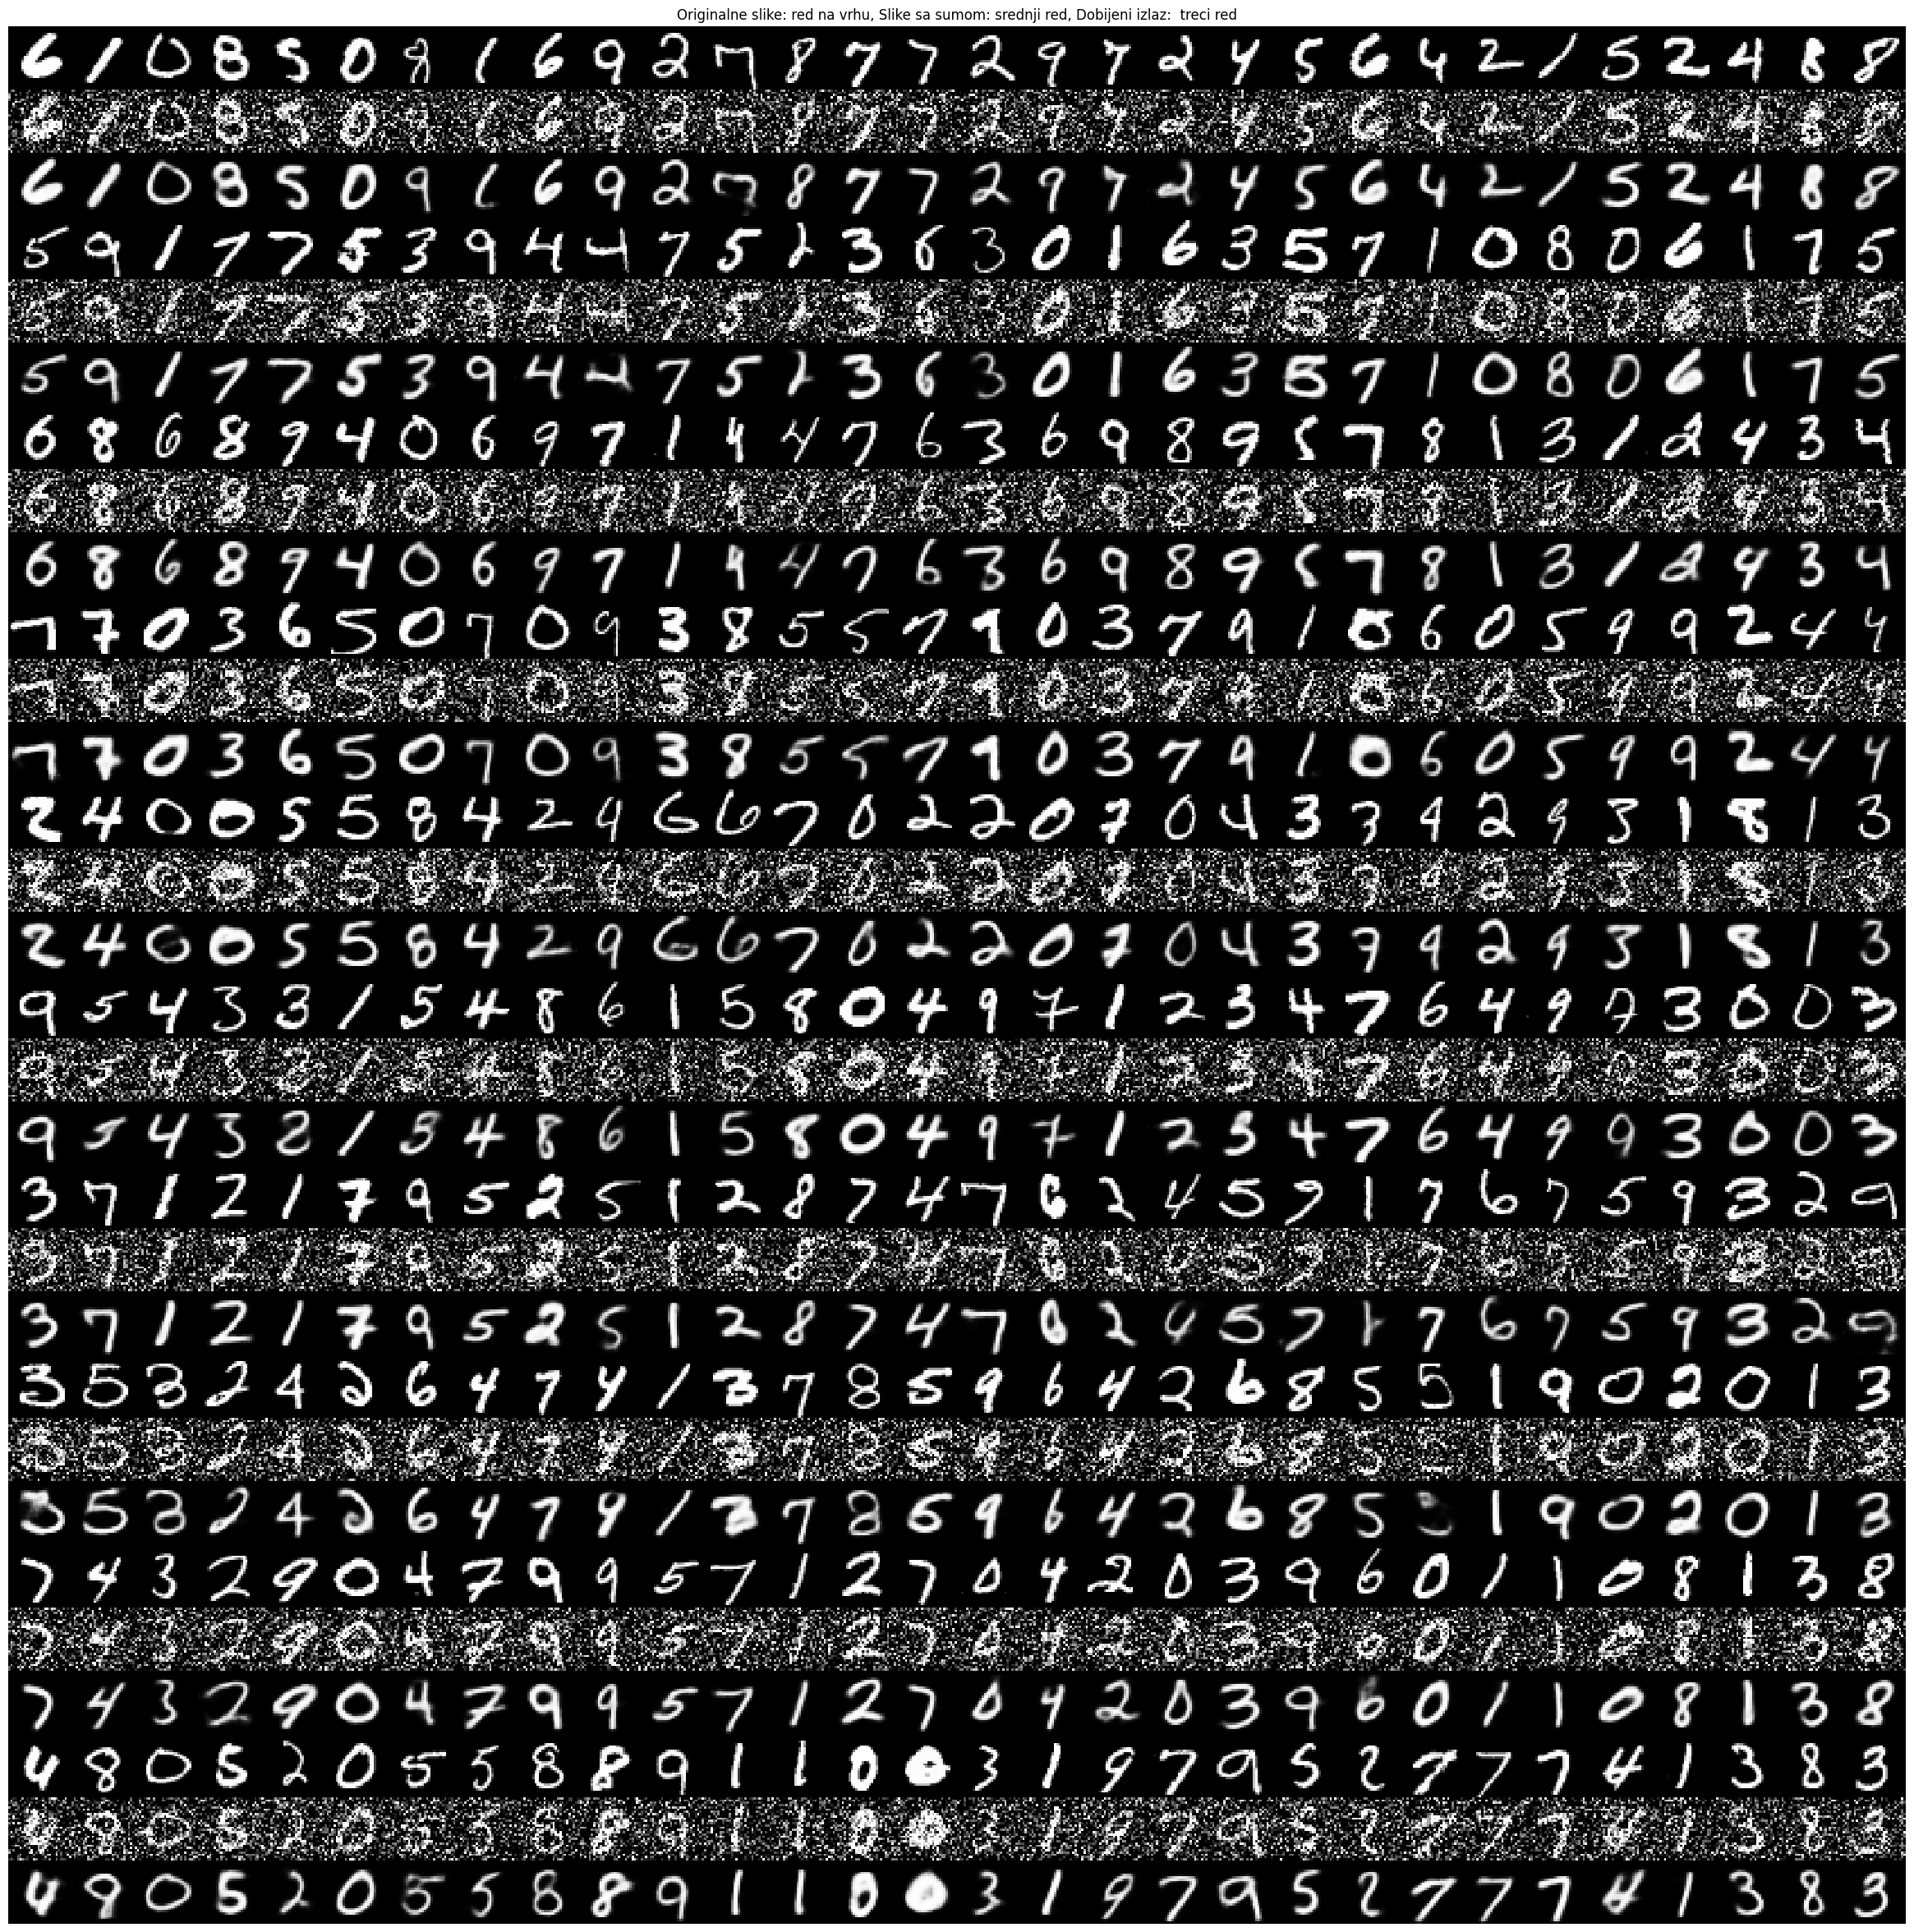

In [34]:
# pripremamo panel za crtanje
plt.figure(figsize=(30, 30))

# izdvojicemo 10x30 slika
rows, cols = 10, 30
num = rows * cols

# izdvajamo odgovarajuce slike: prvo orginalne, zatim sa sumom, a zatim i one koje je genrisao autoenkoder
imgs = np.concatenate([X_test[:num], X_test_noisy[:num], X_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))

# sličice organizujemo tako da imaju opisani oblik
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)

plt.axis('off')
plt.title('Originalne slike: red na vrhu, '
          'Slike sa sumom: srednji red, '
          'Dobijeni izlaz:  treci red')

# prikazujemo slike
plt.imshow(imgs, interpolation='none', cmap='gray')

# čuvamo ovako generisanu sliku
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()